# Camels example

Use test cosmological simulation data (from the [CAMELS simulations](https://www.camel-simulations.org/)) to generate spectra and calculate photometry.

In [25]:
import numpy as np
import matplotlib.pyplot as plt

from synthesizer.grid import Grid
from synthesizer.load_data import load_CAMELS_SIMBA
from synthesizer.sed import Sed
from synthesizer.filters import UVJ

In [5]:
grid_dir = '../../../tests/test_grid'
grid_name = 'test_grid'
grid = Grid(grid_name, grid_dir=grid_dir)

We then need to load our galaxy data. There are custom data loading script for different simulation codes in `synthesizer.load_data`. For CAMELS-Simba there is the `load_CAMELS_SIMBA` method

If your simulation does not have its own front end, please use the templates in `synthesizer/load_data.py` to create your own.

In [6]:
gals = load_CAMELS_SIMBA('../../../tests/', 
                         snap_name='camels_snap.hdf5', 
                         fof_name='camels_subhalo.hdf5')

len(gals)

10

this creates `gals`, which is a list containing a `synthesizer.Galaxy` object for each structure in the subfind file. These `Galaxy` objects contain lots of useful methods for acting on galaxies, one of which is to generate the intrinsic spectrum.

Here we set the `sed_object` flag to `False` to just return an array of luminosity values.

In [12]:
_g = gals[0]
_spec = _g.generate_intrinsic_spectra(grid, sed_object=False)

Here we grab a single galaxy, and call `integrated_stellar_spectrum` providing our grid object as the first argument. This returns the spectra of the galaxy as an array, `_spec`. 

The original wavelength is contained in the grid object - together we can use these to plot the spectrum

Text(0, 0.5, '$L_{\\nu} \\,/\\, \\mathrm{erg \\; s^{-1} \\; Hz^{-1}}$')

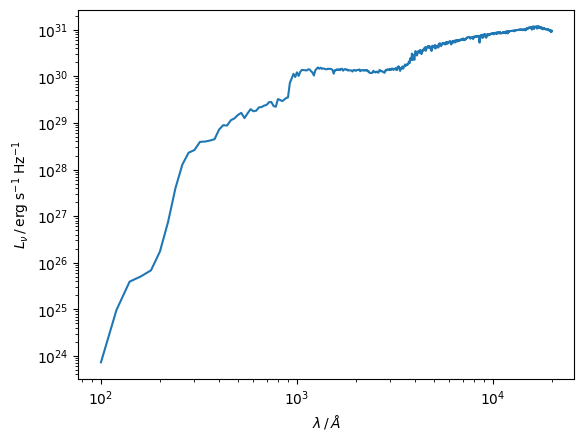

In [15]:
plt.loglog(grid.lam, _spec)
plt.xlabel('$\lambda \,/\, \\AA$')
plt.ylabel('$L_{\\nu} \,/\, \mathrm{erg \; s^{-1} \; Hz^{-1}}$')

### The SED object

We can also specify that `integrated_stellar_spectrum` returns an `Sed` object,

In [19]:
_spec = _g.generate_intrinsic_spectra(grid, sed_object=True)

To access the luminosity and wavelength for `_spec` we can now do

In [22]:
_spec.lam[:10], _spec.lnu[:10]

(unyt_array([100., 120., 140., 160., 180., 200., 220., 240., 260., 280.], 'Å'),
 unyt_array([7.27442945e+23, 9.65568818e+24, 3.91929673e+25,
             5.09711100e+25, 6.86505561e+25, 1.74653111e+26,
             7.51240084e+26, 4.00643721e+27, 1.26914916e+28,
             2.29670263e+28], 'erg/(Hz*s)'))

Notice that these arr unyt arrays with associated units.

Why might you want to create an `Sed` object? This class contains a lot of useful functionality for working with SED's. For example, we can calculate the broadband luminosities.

First, get rest frame 'flux'

In [23]:
_spec.get_fnu0()

Define a filter collection object (UVJ default)

In [28]:
fc = UVJ(new_lam=grid.lam)
_UVJ = _spec.get_broadband_fluxes(fc)
print(_UVJ)

{'U': unyt_quantity(4.9773434e+41, 'nJy'), 'V': unyt_quantity(1.25040598e+42, 'nJy'), 'J': unyt_quantity(2.38255417e+42, 'nJy')}


### Multiple galaxies 
If we want to create spectra for multiple galaxies we can use a list comprehension. Here we leave the `sed_object` flag as `False` during the generation step, and combine into a single sed object afterwards.

In [29]:
_specs = np.vstack([_g.generate_intrinsic_spectra(grid, sed_object=False) for _g in gals])

_specs = Sed(lam=grid.lam, lnu=_specs)

Importantly here, we don't create an SED object for each galaxy spectra. We instead create the 2D array of spectra, and then create an `Sed` object for the whole collection

Text(0, 0.5, '$L_{\\nu} \\,/\\, \\mathrm{erg \\; s^{-1} \\; Hz^{-1}}$')

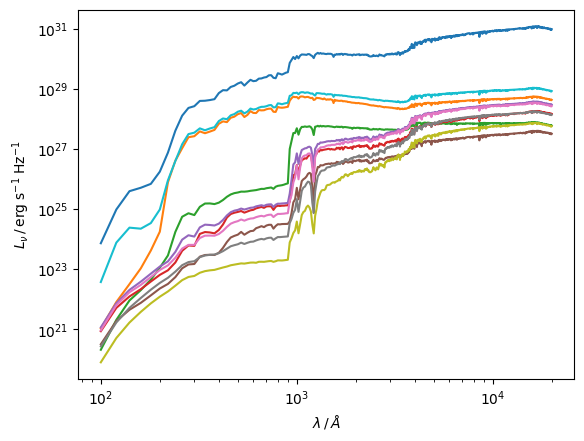

In [110]:
plt.loglog(grid.lam, _specs.lnu.T)
plt.xlabel('$\lambda \,/\, \\AA$')
plt.ylabel('$L_{\\nu} \,/\, \mathrm{erg \; s^{-1} \; Hz^{-1}}$')

### Calculate broadband luminosities

We can then use the `Sed` methods on the whole collection. This is much faster than calling the method for each spectra individually, since we can take advantage of vectorisation. For example, we can calculate UVJ colours of all the selected galaxies in just a couple of lines.

First get rest frame 'flux'

In [111]:
_spec.get_fnu0()

Define a filter collection object (UVJ default)

In [112]:
fc = UVJ(new_lam=grid.lam)

_UVJ = _spec.get_broadband_fluxes(fc)
print(_UVJ)

{'U': unyt_quantity(4.9773434e+41, 'nJy'), 'V': unyt_quantity(1.25040598e+42, 'nJy'), 'J': unyt_quantity(2.38255417e+42, 'nJy')}


Do for multiple, plot UVJ diagram, coloured by $M_{\star}$

In [30]:
mstar = np.log10(np.array([np.sum(_g.stars.initial_masses)
                           for _g in gals]) * 1e10)

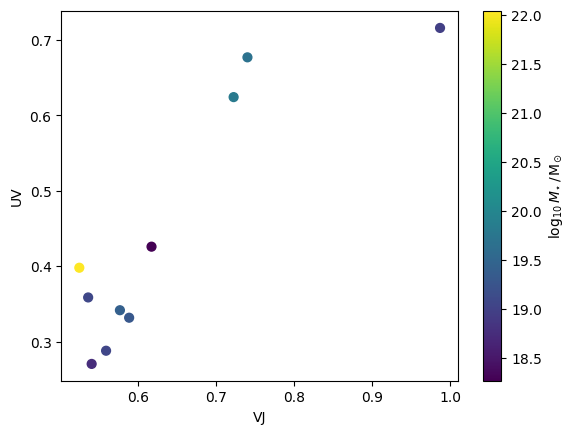

In [114]:
_specs.get_fnu0()
_UVJ = _specs.get_broadband_fluxes(fc)

UV = _UVJ['U'] / _UVJ['V']
VJ = _UVJ['V'] / _UVJ['J']

plt.scatter(VJ, UV, c=mstar, s=40)
plt.xlabel('VJ')
plt.ylabel('UV')
plt.colorbar(label='$\mathrm{log_{10}} \, M_{\star} \,/\, \mathrm{M_{\odot}}$')